<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/don/tinyml-workshop/master/exercises/images/AI-IOT-devfest-AZ-2020-horiz.png" width=200/></a>
# TinyML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/don/tinyml-workshop/

## Setup Python Environment 

Install up the Python libraries and Linux tools for the code in the notebook.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

Selecting previously unselected package xxd.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.3_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.3) ...
Setting up xxd (2:8.0.1453-1ubuntu1.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# Upload Data

1. If necessary, open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab in the left panel
1. Drag the `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

Plot the CSV data on two separate graphs, acceleration and gyroscope, because each data set has different units and scale.

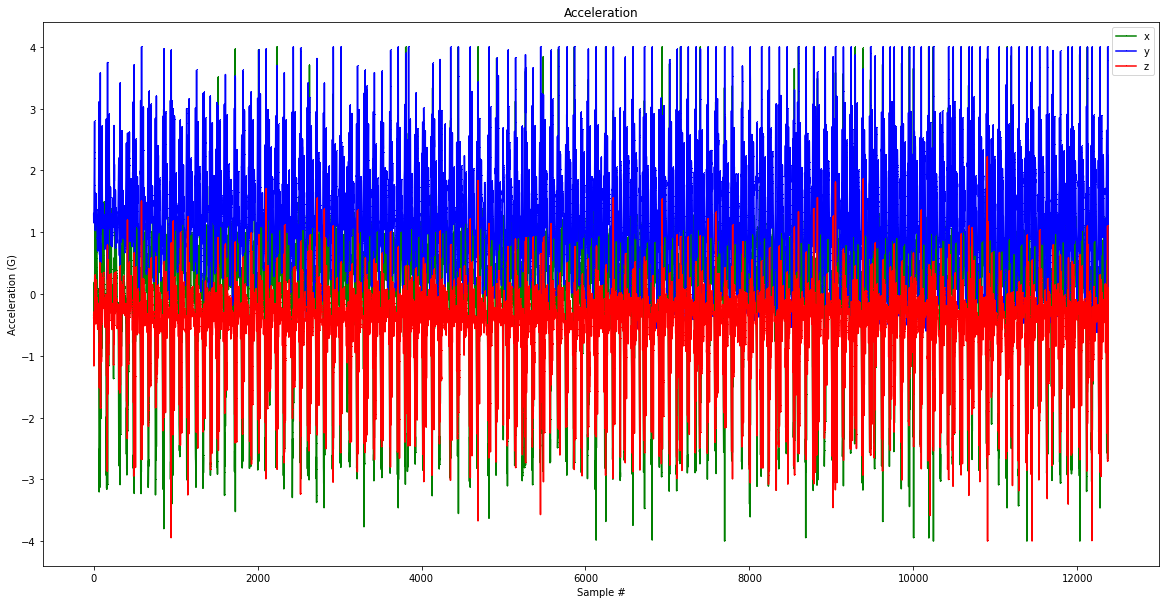

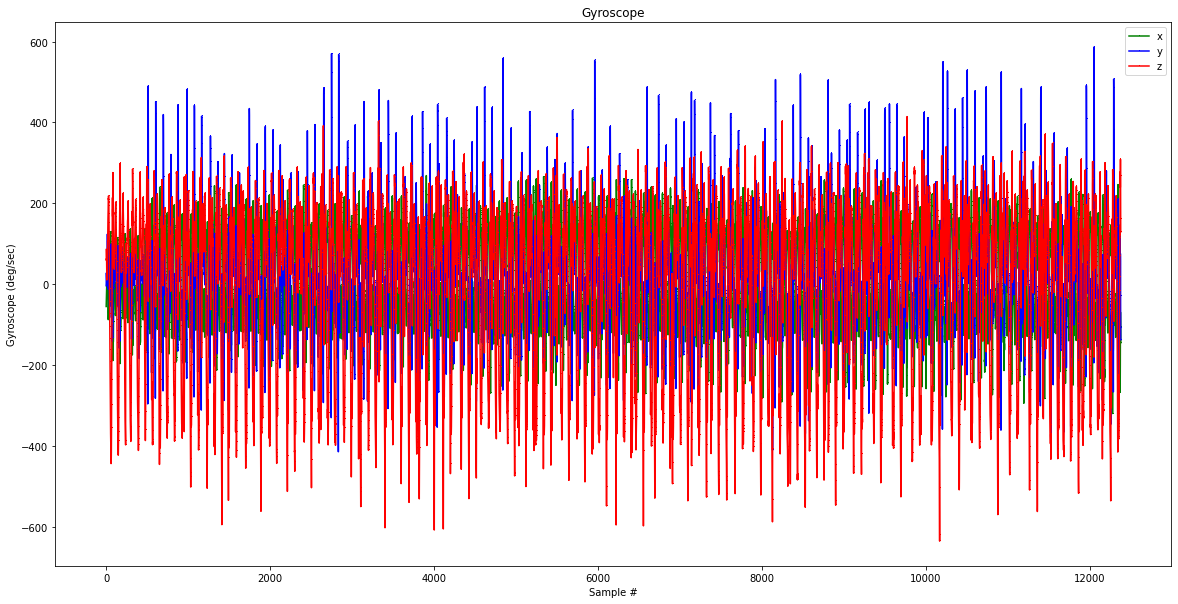

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "Jogging.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


# Train Neural Network





## Parse and prepare the data

Parse the CSV files and transforms them to a format that can be used to train the fully connected neural network.

If you've recorded additional gestures, update the `GESTURES` list with the names of the additional CSV files.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures 
GESTURES = [
    "Jogging",
    "Stationary",
    "Walking",
    "Downstairs",
    "Upstairs"
]

SAMPLES_PER_GESTURE = 119*2

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.2.0

Processing index 0 for gesture 'Jogging'.
	There are 52 recordings of the Jogging gesture.
Processing index 1 for gesture 'Stationary'.
	There are 57 recordings of the Stationary gesture.
Processing index 2 for gesture 'Walking'.
	There are 101 recordings of the Walking gesture.
Processing index 3 for gesture 'Downstairs'.
	There are 49 recordings of the Downstairs gesture.
Processing index 4 for gesture 'Upstairs'.
	There are 59 recordings of the Upstairs gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [5]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='relu'))
# the final layer is softmax because we only expect one gesture to occur per input
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=1000, batch_size=512, validation_data=(inputs_validate, outputs_validate))


Epoch 1/1000
1/1 [==============================] - 0s 209ms/step - loss: 1.6968 - accuracy: 0.1632 - val_loss: 1.6660 - val_accuracy: 0.1538
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 1.6440 - accuracy: 0.1474 - val_loss: 1.6421 - val_accuracy: 0.3385
Epoch 3/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.6095 - accuracy: 0.3579 - val_loss: 1.6630 - val_accuracy: 0.2769
Epoch 4/1000
1/1 [==============================] - 0s 30ms/step - loss: 1.6159 - accuracy: 0.3316 - val_loss: 1.6680 - val_accuracy: 0.2769
Epoch 5/1000
1/1 [==============================] - 0s 30ms/step - loss: 1.6142 - accuracy: 0.3316 - val_loss: 1.6665 - val_accuracy: 0.2769
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.6102 - accuracy: 0.3316 - val_loss: 1.6600 - val_accuracy: 0.2769
Epoch 7/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.6047 - accuracy: 0.3316 - val_loss: 1.6499 - val_accuracy: 0.2769
Epoch 8/1000

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

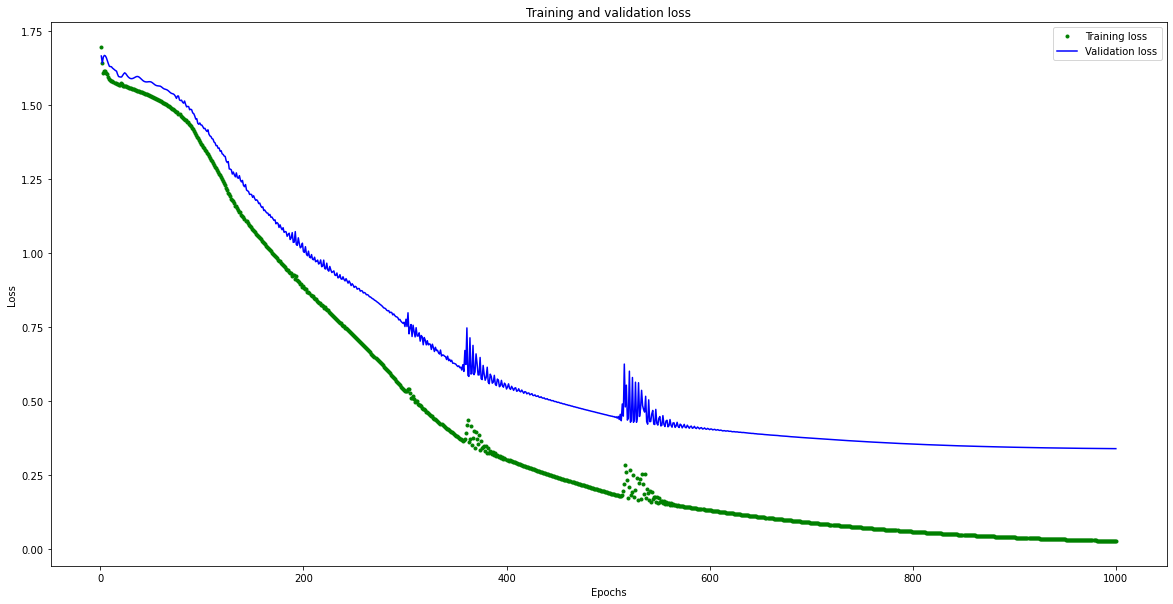

[20.0, 10.0]


In [6]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Run with Test Data
Put our test data into the model and compare the predictions vs actual output


In [7]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

predictions =
 [[0.001 0.    0.007 0.986 0.006]
 [0.989 0.    0.011 0.001 0.   ]
 [0.998 0.    0.    0.002 0.   ]
 [0.    0.018 0.979 0.002 0.   ]
 [0.    0.945 0.052 0.    0.002]
 [0.003 0.    0.056 0.935 0.005]
 [0.001 0.002 0.992 0.005 0.   ]
 [1.    0.    0.    0.    0.   ]
 [0.    0.843 0.141 0.001 0.015]
 [0.    0.141 0.858 0.001 0.   ]
 [0.999 0.    0.    0.    0.   ]
 [0.    0.064 0.934 0.002 0.   ]
 [0.    0.303 0.697 0.    0.   ]
 [0.    0.107 0.891 0.002 0.001]
 [0.    0.993 0.006 0.    0.001]
 [0.    0.002 0.    0.    0.998]
 [0.    0.021 0.975 0.004 0.   ]
 [0.    0.06  0.928 0.01  0.002]
 [0.    0.001 0.    0.137 0.861]
 [0.004 0.001 0.133 0.854 0.009]
 [0.    0.015 0.981 0.004 0.   ]
 [0.998 0.    0.002 0.    0.   ]
 [0.    0.946 0.047 0.    0.007]
 [0.    0.073 0.921 0.005 0.001]
 [0.996 0.    0.004 0.    0.   ]
 [0.001 0.001 0.022 0.93  0.047]
 [0.    0.    0.    0.001 0.999]
 [0.    0.002 0.    0.001 0.997]
 [0.    0.    0.    0.    1.   ]
 [1.    0.    0.    0.    0.

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [8]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 291424 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import the generated model.h file as a tab into your Arduino sketch.

In [9]:
!echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
!cat gesture_model.tflite | xxd -i                                  >> /content/model.h
!echo "};"                                                          >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,797,178 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
